In [1]:
####################################################
##                                                ##
##              Итоговая работа по ML             ##
##                                                ##
####################################################

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

def explore(dataframe):
    
    print("Total Records: ", dataframe.shape[0])
          
    
    x = dataframe.columns[dataframe.isnull().any()].tolist()   
    if not x:
        print("No Missing/Null Records")
    else:        
        print("Found Missing Records")

#Смотрим путь csv хама и спама
def msgs(path):
  data = []
  #path = 'content/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with io.open(path+file, "r", errors='ignore') as f:
      data.append(f.read())
      
  return data



In [2]:
df_train_ham = pd.DataFrame({'Message': msgs('content/train/ham/'), 'Category': 0})
df_train_spam = pd.DataFrame({'Message': msgs('content/train/spam/'), 'Category': 1})

df_test_ham = pd.DataFrame({'Message': msgs('content/test/ham/'), 'Category': 0})
df_test_spam = pd.DataFrame({'Message': msgs('content/test/spam/'), 'Category': 1})

df = pd.concat([df_train_ham, df_train_spam, df_test_ham, df_test_spam], ignore_index=True)
print("Total: ", df.shape)
df.head()


Total:  (33715, 2)


,Message,Category
0,Subject: christmas tree farm pictures\n,0
1,Subject: re : rankings\nthank you .,0
2,Subject: key hr issues going forward\na ) year...,0
3,"Subject: vastar resources , inc .\ngary , prod...",0
4,Subject: congrats !\ncontratulations on the ex...,0


In [3]:
#Разведка данных(можно что-то добавить)
print("Total Number of spam messages in data: ", df[df['Category']==1].shape[0])
print("Total Number of non-spam messages in data: ", df[df['Category']==0].shape[0])

Total Number of spam messages in data:  17170
Total Number of non-spam messages in data:  16545


In [4]:
word_counts = df['Message'].apply(lambda x: len(x.split()))
word_counts.describe()

count    33715.000000
mean       311.613288
std        851.441697
min          1.000000
25%         72.000000
50%        154.000000
75%        330.000000
max      45451.000000
Name: Message, dtype: float64

In [5]:
explore(df)

Total Records:  33715
No Missing/Null Records


In [6]:
#Обработка
import re
import nltk
nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') 
stop_words.remove('not') 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(Message):
    
  # Очиста от ненужного
  Message = re.sub(re.compile('<.*?>'), '', Message) 
  Message =  re.sub('[^A-Za-z0-9]+', ' ', Message) 
  Message = Message.lower()
  
  #Делаем токены
  tokens = nltk.word_tokenize(Message) 

  #Приводим к нормальной форме письма
  Message = [word for word in tokens if word not in stop_words]
  Message = [lemmatizer.lemmatize(word) for word in Message]
  Message = ' '.join(Message)
  
  return Message

df['Preprocessed_Message'] = df['Message'].apply(lambda Message: data_preprocessing(Message))
df.head()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Message,Category,Preprocessed_Message
0,Subject: christmas tree farm pictures\n,0,subject christmas tree farm picture
1,Subject: re : rankings\nthank you .,0,subject ranking thank
2,Subject: key hr issues going forward\na ) year...,0,subject key hr issue going forward year end re...
3,"Subject: vastar resources , inc .\ngary , prod...",0,subject vastar resource inc gary production hi...
4,Subject: congrats !\ncontratulations on the ex...,0,subject congrats contratulations execution cen...


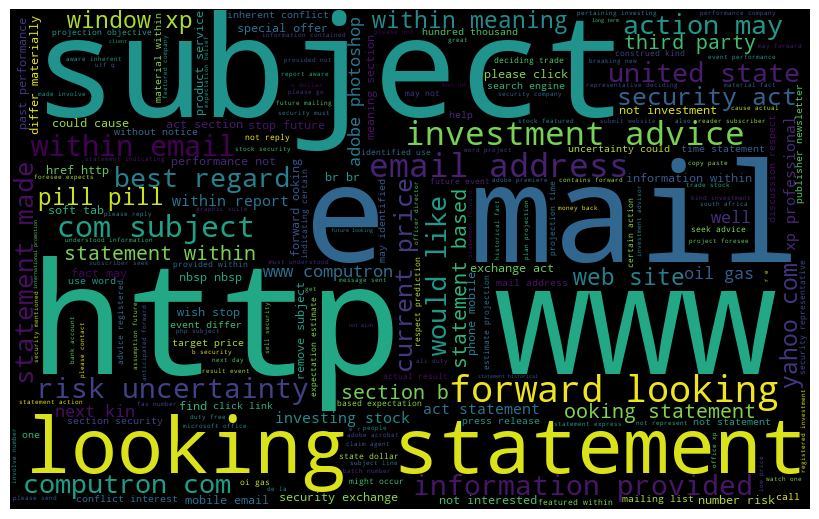

In [7]:
from wordcloud import WordCloud

#Позитивные слова(т.е. те что не могут встречатся в спам письмах)
words_list = df[df['Category']==1]['Preprocessed_Message'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

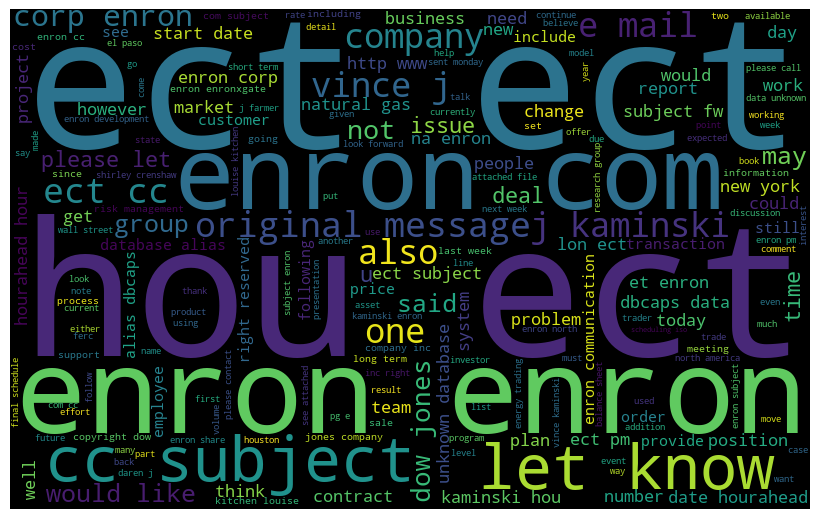

In [8]:
#Спам слова
words_list = df[df['Category']==0]['Preprocessed_Message'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [9]:
#Сплит на тест и треин данные
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['Category'].values
data.drop(['Category'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (23600, 2) (23600,)
Test data: (10115, 2) (10115,)


In [10]:
#Считаем BOW
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10)

X_train_message_bow = vect.fit_transform(X_train['Preprocessed_Message'])
X_test_message_bow = vect.transform(X_test['Preprocessed_Message'])

print('X_train_message_bow shape: ', X_train_message_bow.shape)
print('X_test_message_bow shape: ', X_test_message_bow.shape)

X_train_message_bow shape:  (23600, 18129)
X_test_message_bow shape:  (10115, 18129)


In [11]:
#Считаем TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_message_tfidf = vectorizer.fit_transform(X_train['Preprocessed_Message'])
X_test_message_tfidf = vectorizer.transform(X_test['Preprocessed_Message'])

print('X_train_message_tfidf shape: ', X_train_message_tfidf.shape)
print('X_test_message_tfidf shape: ', X_test_message_tfidf.shape)

X_train_message_tfidf shape:  (23600, 18129)
X_test_message_tfidf shape:  (10115, 18129)


In [22]:
#теорема Байса(Наивный Байс) через BOW
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = MultinomialNB()
clf.fit(X_train_message_bow, y_train)

y_pred = clf.predict(X_test_message_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Precision: ', precision_score(y_test, y_pred))
print('Test Recall: ', recall_score(y_test, y_pred))

Test Accuracy:  0.9836875926841325
Test Precision:  0.983889751552795
Test Recall:  0.9840807610172781


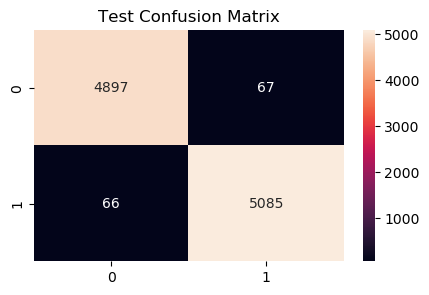

In [24]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [23]:
#теорема Байса(Наивный Байс) через TFIDF
clf = MultinomialNB(alpha=1)
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Precision: ', precision_score(y_test, y_pred))
print('Test Recall: ', recall_score(y_test, y_pred))

Test Accuracy:  0.9868512110726644
Test Precision:  0.9869953416149069
Test Recall:  0.9871869539895166


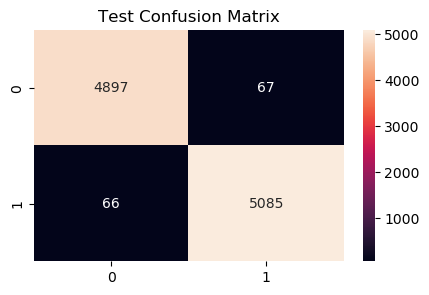

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [25]:
#Лог регрессия через TFIDF
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

clf = LogisticRegression(penalty='l2')
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Precision: ', precision_score(y_test, y_pred))
print('Test Recall: ', recall_score(y_test, y_pred))

Test Accuracy:  0.9885318833415719
Test Precision:  0.9812655324029822
Test Recall:  0.9965055329062318


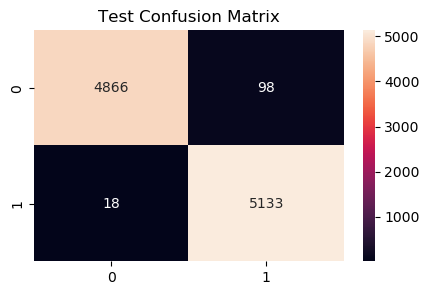

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [26]:

#Тупо все результаты исследования
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall']
x.add_row(['BOW', 'Naive Bayes', '97.3%', '98.3%', '98.4%'])
x.add_row(['TFIDF', 'Naive Bayes', '98.6%', '98.6%', '98.7%'])
x.add_row(['TFIDF', 'Logistic Regression', '98.8%', '98.1%', '99.6%'])
print(x)



+------------+---------------------+----------+-----------+--------+
| Vectorizer |        Model        | Accuracy | Precision | Recall |
+------------+---------------------+----------+-----------+--------+
|    BOW     |     Naive Bayes     |  97.3%   |   98.3%   | 98.4%  |
|   TFIDF    |     Naive Bayes     |  98.6%   |   98.6%   | 98.7%  |
|   TFIDF    | Logistic Regression |  98.8%   |   98.1%   | 99.6%  |
+------------+---------------------+----------+-----------+--------+
